# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [12]:
import pandas as pd

tr_path = './data/covid.train.csv'  # path to training data
tt_path = './data/covid.test.csv'   # path to testing data

# **Import Some Packages**

In [53]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch.utils.tensorboard
import seaborn as sns
myseed = 142857  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

<AxesSubplot:>

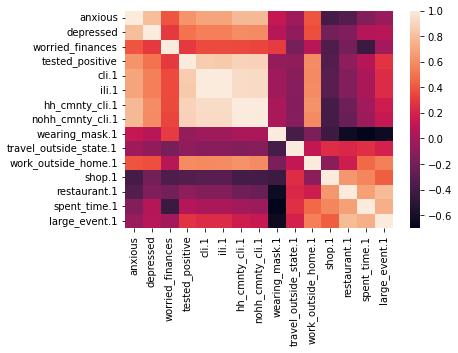

In [60]:
train_data = pd.read_csv(tr_path)
corr = train_data.iloc[:, 50:65].corr()
sns.heatmap(corr)

In [59]:
train_data.iloc[:, 41:57]

,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1
0,8.556230,76.521693,7.863621,33.069066,64.129378,33.438714,40.539878,17.446499,3.993190,10.122837,7.841023,37.992365,7.374846,0.653157,0.713249,12.488933
1,11.091818,82.375469,11.082587,36.373964,60.471825,30.516978,43.162123,16.038761,4.519762,12.133287,10.155721,33.977549,9.850027,0.738029,0.720511,15.070049
2,5.238097,87.040999,15.569851,33.366362,58.819368,24.674416,36.678937,13.490946,6.639301,9.753290,7.691015,38.685771,3.897851,0.663597,0.635459,8.472831
3,7.219741,43.153686,20.972589,35.458649,69.833774,37.021123,48.022187,28.436903,4.083615,9.417865,9.385772,37.621189,10.297712,1.356577,1.432775,12.997184
4,16.829163,28.556052,20.619196,34.824775,68.468540,38.046432,49.785967,23.441813,3.829427,10.988948,8.838078,29.949690,24.056627,1.298511,1.231606,20.189998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,19.457059,43.967532,18.467811,39.679352,66.330449,38.150355,47.260560,22.881724,3.429600,14.820469,11.055155,33.458132,10.788842,1.171500,1.163963,23.816931
2695,7.894431,49.831306,13.342331,29.468741,63.606308,29.921119,39.885167,16.361208,13.704907,13.024713,9.542967,37.527582,5.801104,0.655551,0.660840,11.519438
2696,24.115854,63.979954,14.152762,33.162706,63.070285,30.068706,40.943155,18.620308,2.351808,16.374529,12.356715,41.139407,13.879613,1.728777,1.721787,29.207283
2697,9.940158,39.334957,10.821896,30.758436,66.803328,34.972873,46.955567,19.339536,3.007822,12.290752,10.150008,29.543377,8.795563,0.840583,0.829843,13.205292


# **Some Utilities**

You do not need to modify this part.

In [14]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [69]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            feats = list(range(40))
            feats.append(42)
            feats.append(43)
            feats.append(46)
            feats.append(57)
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [70]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [71]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [72]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [73]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [74]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [80]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')

os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                  # TODO: Using 40 states & 2 tested_positive features
# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 256,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.005,
        'weight_decay': 0.01
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'C:\\Users\\ydc2020\\OneDrive\\桌面\\2022暑期\\Deep Learning\\models\\model.txt'  # your model will be saved here
}

# **Load data and model**

In [76]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2429 samples found, each dim = 44)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 44)
Finished reading the test set of COVID19 Dataset (1078 samples found, each dim = 44)


In [81]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [82]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 11.6825)
Saving model (epoch =    2, loss = 10.7713)
Saving model (epoch =    3, loss = 7.7782)
Saving model (epoch =    4, loss = 6.8717)
Saving model (epoch =    6, loss = 6.3834)
Saving model (epoch =    7, loss = 6.1794)
Saving model (epoch =    8, loss = 5.8086)
Saving model (epoch =    9, loss = 5.6461)
Saving model (epoch =   11, loss = 5.4216)
Saving model (epoch =   14, loss = 5.0646)
Saving model (epoch =   16, loss = 4.7976)
Saving model (epoch =   21, loss = 4.6920)
Saving model (epoch =   25, loss = 4.5436)
Saving model (epoch =   28, loss = 4.3921)
Saving model (epoch =   29, loss = 4.3005)
Saving model (epoch =   35, loss = 4.1839)
Saving model (epoch =   45, loss = 3.9842)
Saving model (epoch =   50, loss = 3.9107)
Saving model (epoch =   54, loss = 3.8939)
Saving model (epoch =   55, loss = 3.7090)
Saving model (epoch =   56, loss = 3.6957)
Saving model (epoch =   64, loss = 3.6450)
Saving model (epoch =   72, loss = 3.6115)
Saving mo

'cuda'

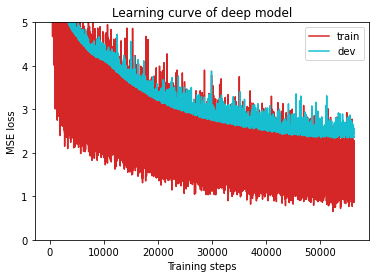

In [79]:
plot_learning_curve(model_loss_record, title='deep model')

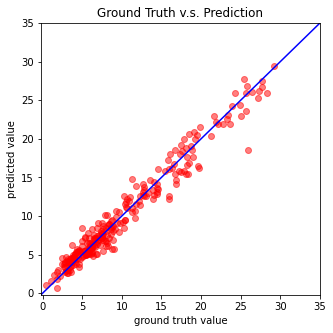

In [16]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
